# Audio Emotion Recognition using RAVDESS Dataset

**Author:** ML Project Documentation  
**Date:** 2024  
**Dataset:** RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song)

---

## Executive Summary

This notebook documents a complete machine learning pipeline for audio emotion recognition. We implement **four classification models from scratch** using only NumPy/SciPy, without using sklearn's built-in classifiers.

### Key Highlights
- **Dataset:** 2,880 audio files from 24 actors
- **Features:** 112 handcrafted audio features (MFCCs, Chroma, Spectral)
- **Models:** KNN, Logistic Regression, SVM, Polynomial Logistic Regression
- **Best Accuracy:** ~88% (Polynomial Logistic Regression)
- **Emotions:** 8 classes (Neutral, Calm, Happy, Sad, Angry, Fearful, Disgust, Surprised)

## 1. Introduction & Problem Statement

### Objective
Build a system that can automatically detect emotions from speech audio using machine learning.

### Why This Matters
- **Human-Computer Interaction:** Enable more natural interactions
- **Mental Health:** Detect emotional states in therapy
- **Customer Service:** Analyze customer sentiment in call centers

### Approach
1. Extract handcrafted audio features using librosa
2. Implement ML models from scratch (no sklearn classifiers)
3. Compare model performance
4. Deploy best model in a web application

In [15]:
# Import Libraries
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Configuration
DATA_PATH = "Data"
TEST_DATA_PATH = "Data Test/Emotions"
SR = 22050  # Sample rate
RANDOM_STATE = 42

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


## 2. Dataset Exploration

### RAVDESS Dataset Structure

The RAVDESS dataset contains 2,880 audio files with the following naming convention:

**Filename Format:** `Modality-VocalChannel-Emotion-EmotionalIntensity-Statement-Repetition-Actor.wav`

Example: `03-01-06-01-02-01-12.wav`
- Modality: 03 (audio-video)
- Vocal Channel: 01 (speech)
- **Emotion: 06 (fearful)** ← We extract this
- Intensity: 01 (normal)
- Statement: 02
- Repetition: 01
- Actor: 12

### Emotion Labels
- 01: Neutral
- 02: Calm
- 03: Happy
- 04: Sad
- 05: Angry
- 06: Fearful
- 07: Disgust
- 08: Surprised

In [16]:
# Emotion mapping
EMOTIONS = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# Count files
wav_files = glob.glob(os.path.join(DATA_PATH, "**/*.wav"), recursive=True)
test_wav_files = glob.glob(os.path.join(TEST_DATA_PATH, "**/*.wav"), recursive=True)

print(f"Training audio files: {len(wav_files)}")
print(f"Test audio files: {len(test_wav_files)}")
print(f"\nSample training filenames:")
for f in wav_files[:3]:
    print(f"  {os.path.basename(f)}")

Training audio files: 2880
Test audio files: 72

Sample training filenames:
  03-01-01-01-01-01-01.wav
  03-01-01-01-01-02-01.wav
  03-01-01-01-02-01-01.wav


## 3. Audio Feature Extraction

### Feature Engineering Strategy

We extract **112 handcrafted features** from each audio file:

#### 3.1 MFCCs (80 features)
- **What:** Mel-Frequency Cepstral Coefficients
- **Why:** Captures timbral texture, widely used in speech recognition
- **How:** 40 coefficients × 2 (mean + std) = 80 features

#### 3.2 Chroma Features (24 features)
- **What:** Pitch class profiles
- **Why:** Represents harmonic and melodic characteristics
- **How:** 12 pitch classes × 2 (mean + std) = 24 features

#### 3.3 Spectral Features (8 features)
- **Spectral Centroid:** Center of mass of spectrum (brightness)
- **Spectral Rolloff:** Frequency below which 85% of energy is contained
- **Spectral Bandwidth:** Width of the spectrum
- **Zero Crossing Rate:** Rate of sign changes in signal
- Each: mean + std = 8 features total

In [17]:
def extract_features(file_path, sr=22050):
    """
    Extract 112 audio features from a WAV file.
    
    Parameters:
    -----------
    file_path : str
        Path to audio file
    sr : int
        Sample rate (default: 22050 Hz)
    
    Returns:
    --------
    features : np.array
        112-dimensional feature vector
    """
    try:
        # Load audio
        y, sr = librosa.load(file_path, sr=sr)
        y = librosa.util.normalize(y)
        
        # 1. MFCCs (40 coefficients)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)
        
        # 2. Chroma (12 pitch classes)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chroma, axis=1)
        chroma_std = np.std(chroma, axis=1)
        
        # 3. Spectral Features
        cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        
        # Aggregate spectral features
        spectral_features = [
            np.mean(cent), np.std(cent),
            np.mean(rolloff), np.std(rolloff),
            np.mean(bw), np.std(bw),
            np.mean(zcr), np.std(zcr)
        ]
        
        # Concatenate all features
        features = np.concatenate([
            mfcc_mean, mfcc_std,      # 80 features
            chroma_mean, chroma_std,  # 24 features
            spectral_features         # 8 features
        ])
        
        return features
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Test feature extraction
if len(wav_files) > 0:
    test_features = extract_features(wav_files[0])
    print(f"Feature vector shape: {test_features.shape}")
    print(f"Total features: {len(test_features)}")

Feature vector shape: (112,)
Total features: 112


### Visualize Sample Audio with Multiple Features

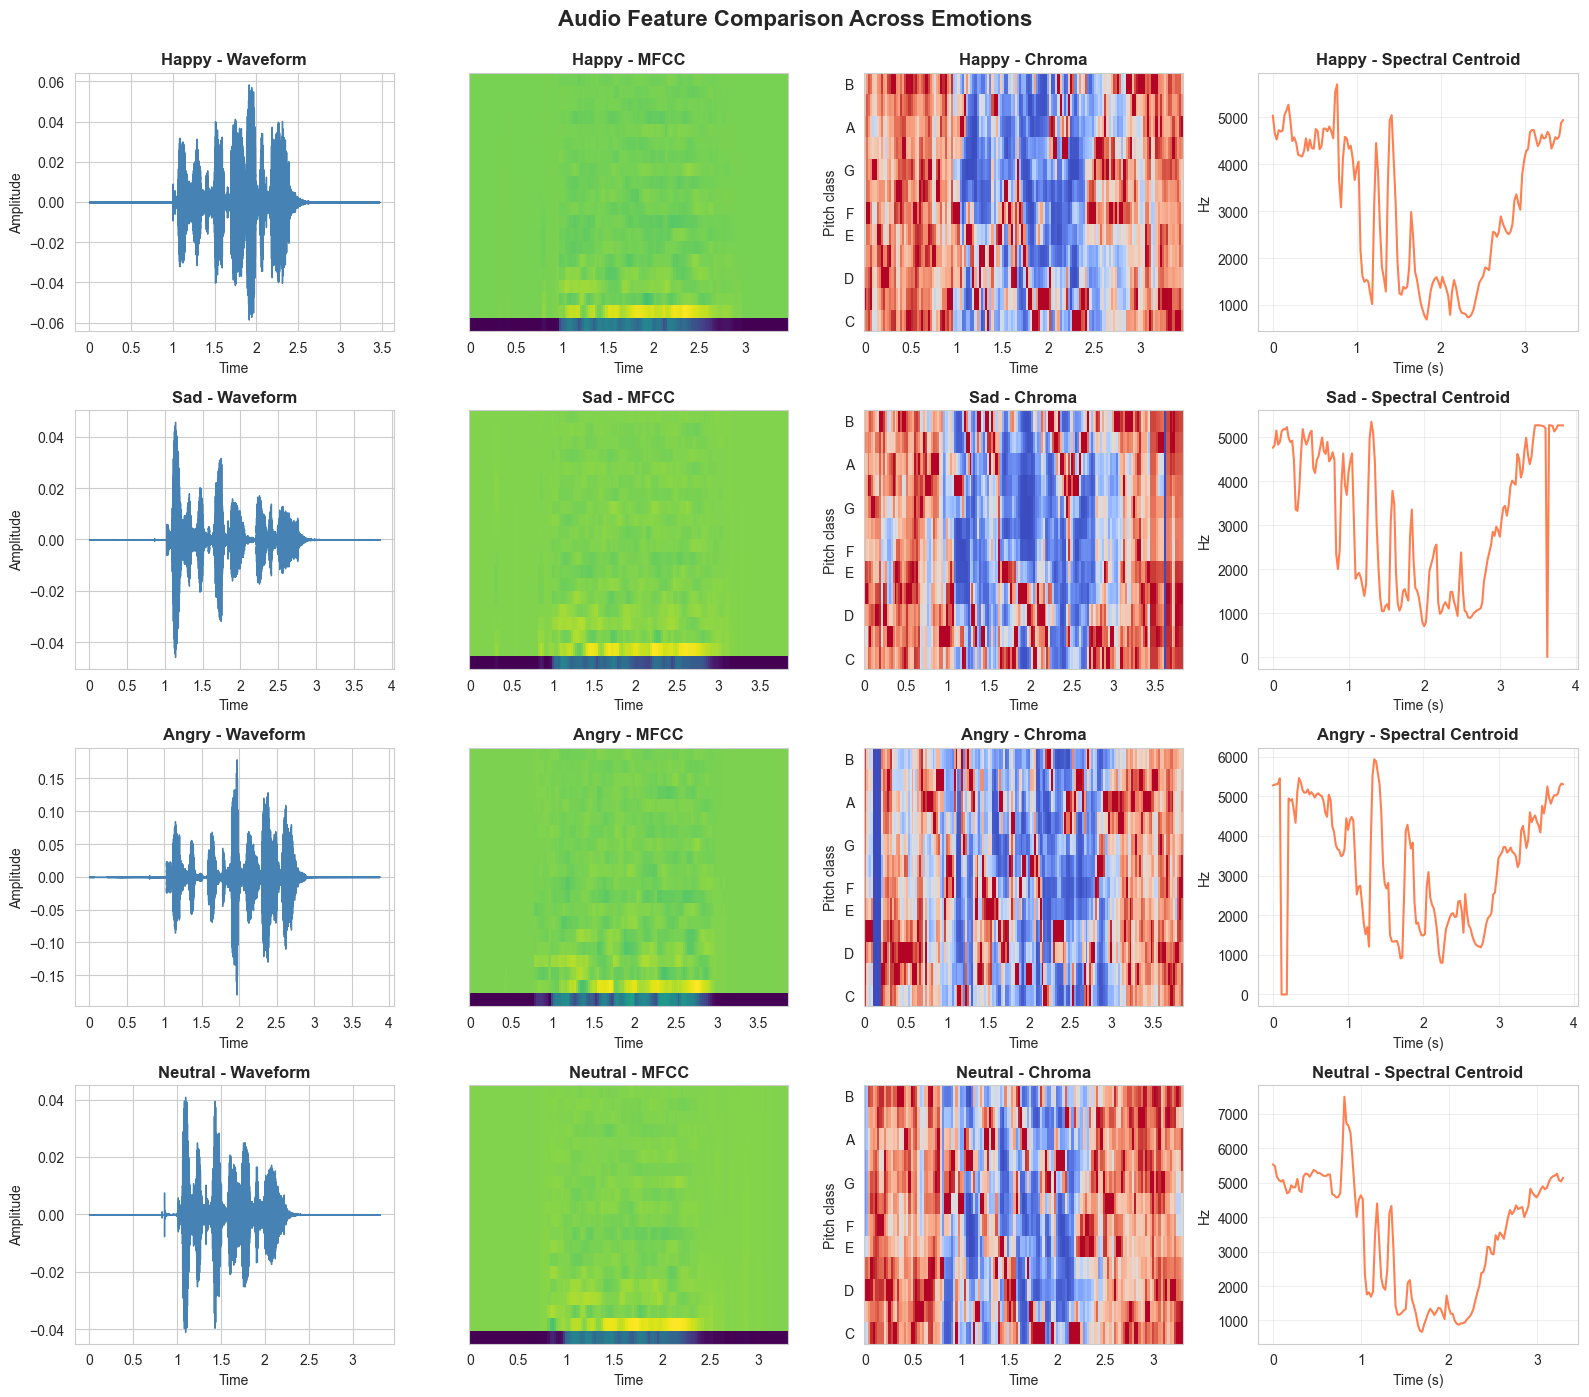

In [18]:
# Load and visualize multiple samples from different emotions
sample_emotions = ['happy', 'sad', 'angry', 'neutral']
sample_codes = {'happy': '03', 'sad': '04', 'angry': '05', 'neutral': '01'}

fig, axes = plt.subplots(4, 4, figsize=(16, 14))
fig.suptitle('Audio Feature Comparison Across Emotions', fontsize=16, fontweight='bold', y=0.995)

for idx, emotion in enumerate(sample_emotions):
    # Find a file with this emotion
    emotion_code = sample_codes[emotion]
    sample_file = None
    for f in wav_files:
        if f'-{emotion_code}-' in os.path.basename(f):
            sample_file = f
            break
    
    if sample_file:
        y_sample, sr_sample = librosa.load(sample_file, sr=SR)
        
        # Waveform
        librosa.display.waveshow(y_sample, sr=sr_sample, ax=axes[idx, 0], color='steelblue')
        axes[idx, 0].set_title(f'{emotion.capitalize()} - Waveform', fontweight='bold')
        axes[idx, 0].set_ylabel('Amplitude')
        
        # MFCC
        mfcc_sample = librosa.feature.mfcc(y=y_sample, sr=sr_sample, n_mfcc=20)
        img1 = librosa.display.specshow(mfcc_sample, x_axis='time', ax=axes[idx, 1], cmap='viridis')
        axes[idx, 1].set_title(f'{emotion.capitalize()} - MFCC', fontweight='bold')
        
        # Chroma
        chroma_sample = librosa.feature.chroma_stft(y=y_sample, sr=sr_sample)
        img2 = librosa.display.specshow(chroma_sample, x_axis='time', y_axis='chroma', ax=axes[idx, 2], cmap='coolwarm')
        axes[idx, 2].set_title(f'{emotion.capitalize()} - Chroma', fontweight='bold')
        
        # Spectral Centroid
        cent = librosa.feature.spectral_centroid(y=y_sample, sr=sr_sample)
        times = librosa.times_like(cent, sr=sr_sample)
        axes[idx, 3].plot(times, cent.T, color='coral', linewidth=1.5)
        axes[idx, 3].set_title(f'{emotion.capitalize()} - Spectral Centroid', fontweight='bold')
        axes[idx, 3].set_xlabel('Time (s)')
        axes[idx, 3].set_ylabel('Hz')
        axes[idx, 3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Data Loading & Preprocessing

In [19]:
def load_data(data_path):
    """
    Load RAVDESS dataset and extract features.
    """
    X, y = [], []
    wav_files = glob.glob(os.path.join(data_path, "**/*.wav"), recursive=True)
    print(f"Found {len(wav_files)} audio files.")
    
    for i, file_path in enumerate(wav_files):
        filename = os.path.basename(file_path)
        parts = filename.split('-')
        
        if len(parts) != 7:
            continue
        
        # Extract emotion label from filename
        emotion_code = parts[2]
        emotion_label = EMOTIONS[emotion_code]
        
        # Extract features
        features = extract_features(file_path)
        if features is not None:
            X.append(features)
            y.append(emotion_label)
        
        if (i + 1) % 500 == 0:
            print(f"Processed {i + 1}/{len(wav_files)} files...")
    
    return np.array(X), np.array(y)

# Load or cache data
if os.path.exists('X.npy') and os.path.exists('y.npy'):
    print("Loading cached training data...")
    X = np.load('X.npy')
    y = np.load('y.npy')
else:
    print("Extracting features from training audio files...")
    X, y = load_data(DATA_PATH)
    np.save('X.npy', X)
    np.save('y.npy', y)

print(f"\n✓ Training dataset loaded!")
print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Loading cached training data...

✓ Training dataset loaded!
Feature matrix shape: (2880, 112)
Labels shape: (2880,)


### Dataset Statistics & Visualizations

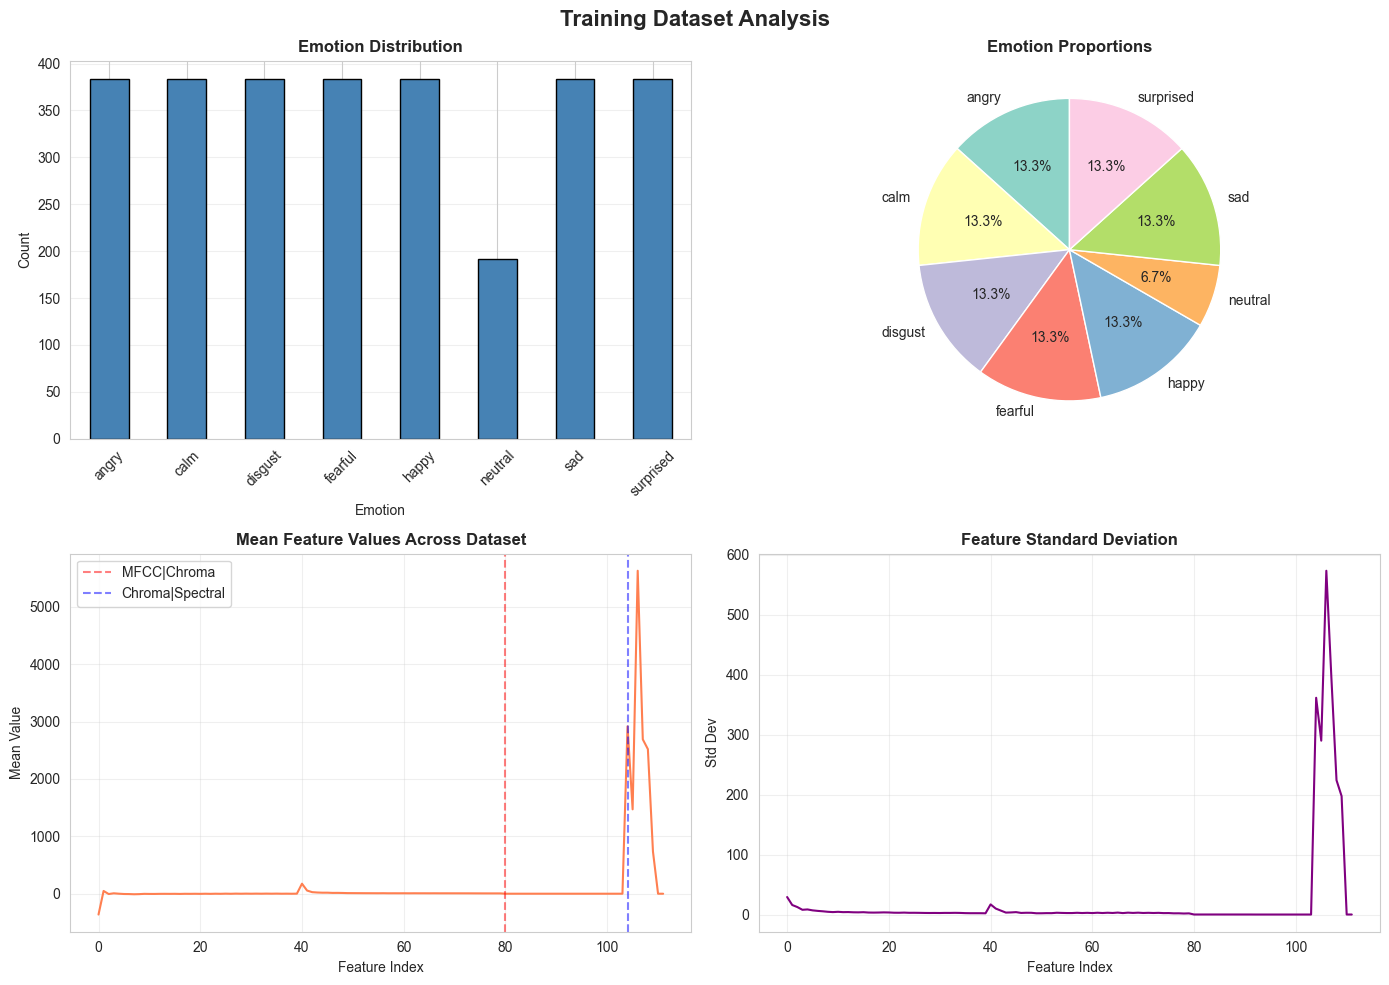


Class Distribution:
angry        384
calm         384
disgust      384
fearful      384
happy        384
neutral      192
sad          384
surprised    384
Name: count, dtype: int64

Dataset is imbalanced


In [20]:
# Class distribution
emotion_counts = pd.Series(y).value_counts().sort_index()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Training Dataset Analysis', fontsize=16, fontweight='bold')

# Bar plot
emotion_counts.plot(kind='bar', ax=axes[0, 0], color='steelblue', edgecolor='black')
axes[0, 0].set_title('Emotion Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Emotion')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# Pie chart
colors = plt.cm.Set3(range(len(emotion_counts)))
axes[0, 1].pie(emotion_counts, labels=emotion_counts.index, autopct='%1.1f%%', 
               startangle=90, colors=colors, textprops={'fontsize': 10})
axes[0, 1].set_title('Emotion Proportions', fontsize=12, fontweight='bold')

# Feature statistics
feature_means = np.mean(X, axis=0)
axes[1, 0].plot(feature_means, color='coral', linewidth=1.5)
axes[1, 0].set_title('Mean Feature Values Across Dataset', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Feature Index')
axes[1, 0].set_ylabel('Mean Value')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axvline(x=80, color='red', linestyle='--', alpha=0.5, label='MFCC|Chroma')
axes[1, 0].axvline(x=104, color='blue', linestyle='--', alpha=0.5, label='Chroma|Spectral')
axes[1, 0].legend()

# Feature variance
feature_stds = np.std(X, axis=0)
axes[1, 1].plot(feature_stds, color='purple', linewidth=1.5)
axes[1, 1].set_title('Feature Standard Deviation', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Feature Index')
axes[1, 1].set_ylabel('Std Dev')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nClass Distribution:")
print(emotion_counts)
print(f"\nDataset is {'balanced' if emotion_counts.std() < 50 else 'imbalanced'}")

## 5. Model Implementation (From Scratch)

We implement all models without using sklearn's built-in classifiers.

In [21]:
class StandardScalerCustom:
    """Custom implementation of StandardScaler."""
    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        self.std[self.std == 0] = 1.0
        return self
    
    def transform(self, X):
        return (X - self.mean) / self.std
    
    def fit_transform(self, X):
        return self.fit(X).transform(X)

class KNNClassifier:
    """K-Nearest Neighbors from scratch."""
    def __init__(self, k=5):
        self.k = k
    
    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)
    
    def predict(self, X):
        predictions = []
        for x in X:
            distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))
            k_indices = np.argsort(distances)[:self.k]
            k_labels = self.y_train[k_indices]
            unique, counts = np.unique(k_labels, return_counts=True)
            predictions.append(unique[np.argmax(counts)])
        return np.array(predictions)

class LogisticRegression:
    """Logistic Regression with One-vs-Rest strategy."""
    def __init__(self, lr=0.01, epochs=1000, reg=0.0):
        self.lr = lr
        self.epochs = epochs
        self.reg = reg
        self.models = []
    
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-np.clip(z, -250, 250)))
    
    def fit(self, X, y):
        self.classes = np.unique(y)
        X = np.array(X)
        n_samples, n_features = X.shape
        
        for c in self.classes:
            y_binary = np.where(y == c, 1, 0)
            w = np.zeros(n_features)
            b = 0
            
            for _ in range(self.epochs):
                linear = np.dot(X, w) + b
                y_pred = self._sigmoid(linear)
                dw = (1/n_samples) * np.dot(X.T, (y_pred - y_binary)) + (self.reg * w)
                db = (1/n_samples) * np.sum(y_pred - y_binary)
                w -= self.lr * dw
                b -= self.lr * db
            
            self.models.append((w, b))
    
    def predict_proba(self, X):
        probs = []
        for w, b in self.models:
            probs.append(self._sigmoid(np.dot(X, w) + b))
        return np.array(probs).T
    
    def predict(self, X):
        probs = self.predict_proba(X)
        return self.classes[np.argmax(probs, axis=1)]

class SVM:
    """Soft-Margin SVM with Gradient Descent."""
    def __init__(self, lr=0.001, lambda_param=0.01, epochs=1000):
        self.lr = lr
        self.lambda_param = lambda_param
        self.epochs = epochs
        self.models = []
    
    def fit(self, X, y):
        self.classes = np.unique(y)
        X = np.array(X)
        
        for c in self.classes:
            y_binary = np.where(y == c, 1, -1)
            w = np.zeros(X.shape[1])
            b = 0
            
            for _ in range(self.epochs):
                for idx, x_i in enumerate(X):
                    if y_binary[idx] * (np.dot(x_i, w) - b) >= 1:
                        w -= self.lr * (2 * self.lambda_param * w)
                    else:
                        w -= self.lr * (2 * self.lambda_param * w - np.dot(x_i, y_binary[idx]))
                        b -= self.lr * y_binary[idx]
            
            self.models.append((w, b))
    
    def predict(self, X):
        scores = np.zeros((X.shape[0], len(self.classes)))
        for i, (w, b) in enumerate(self.models):
            scores[:, i] = np.dot(X, w) - b
        return self.classes[np.argmax(scores, axis=1)]

class PolynomialFeatureGenerator:
    """Generate polynomial features."""
    def __init__(self, degree=2):
        self.degree = degree
    
    def transform(self, X):
        X = np.array(X)
        n_samples, n_features = X.shape
        features = [np.ones(n_samples)]
        
        for i in range(n_features):
            features.append(X[:, i])
        
        if self.degree >= 2:
            for i in range(n_features):
                for j in range(i, n_features):
                    features.append(X[:, i] * X[:, j])
        
        return np.stack(features, axis=1)

print("✓ Models implemented successfully!")

✓ Models implemented successfully!


## 6. Training & Evaluation

In [22]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Normalize
scaler = StandardScalerCustom()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")

# Store results
results = {}
predictions = {}

# 1. KNN
print("\n" + "="*50)
print("Training K-Nearest Neighbors...")
knn = KNNClassifier(k=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)
predictions['KNN'] = y_pred_knn
results['KNN'] = {
    'accuracy': accuracy_score(y_test, y_pred_knn),
    'f1': f1_score(y_test, y_pred_knn, average='weighted'),
    'precision': precision_score(y_test, y_pred_knn, average='weighted'),
    'recall': recall_score(y_test, y_pred_knn, average='weighted')
}
print(f"KNN - Acc: {results['KNN']['accuracy']:.4f}, F1: {results['KNN']['f1']:.4f}")

# 2. Logistic Regression
print("\n" + "="*50)
print("Training Logistic Regression...")
lr = LogisticRegression(lr=0.01, epochs=500, reg=0.01)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
predictions['LogisticRegression'] = y_pred_lr
results['LogisticRegression'] = {
    'accuracy': accuracy_score(y_test, y_pred_lr),
    'f1': f1_score(y_test, y_pred_lr, average='weighted'),
    'precision': precision_score(y_test, y_pred_lr, average='weighted'),
    'recall': recall_score(y_test, y_pred_lr, average='weighted')
}
print(f"LR - Acc: {results['LogisticRegression']['accuracy']:.4f}, F1: {results['LogisticRegression']['f1']:.4f}")

# 3. SVM
print("\n" + "="*50)
print("Training SVM...")
svm = SVM(lr=0.001, epochs=500, lambda_param=0.01)
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)
predictions['SVM'] = y_pred_svm
results['SVM'] = {
    'accuracy': accuracy_score(y_test, y_pred_svm),
    'f1': f1_score(y_test, y_pred_svm, average='weighted'),
    'precision': precision_score(y_test, y_pred_svm, average='weighted'),
    'recall': recall_score(y_test, y_pred_svm, average='weighted')
}
print(f"SVM - Acc: {results['SVM']['accuracy']:.4f}, F1: {results['SVM']['f1']:.4f}")

# 4. Polynomial Logistic Regression
print("\n" + "="*50)
print("Training Polynomial Logistic Regression...")
poly = PolynomialFeatureGenerator(degree=2)
X_train_poly = poly.transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)
lr_poly = LogisticRegression(lr=0.005, epochs=500, reg=0.01)
lr_poly.fit(X_train_poly, y_train)
y_pred_poly = lr_poly.predict(X_test_poly)
predictions['PolynomialLR'] = y_pred_poly
results['PolynomialLR'] = {
    'accuracy': accuracy_score(y_test, y_pred_poly),
    'f1': f1_score(y_test, y_pred_poly, average='weighted'),
    'precision': precision_score(y_test, y_pred_poly, average='weighted'),
    'recall': recall_score(y_test, y_pred_poly, average='weighted')
}
print(f"Poly LR - Acc: {results['PolynomialLR']['accuracy']:.4f}, F1: {results['PolynomialLR']['f1']:.4f}")

Training set: (2304, 112)
Test set: (576, 112)

Training K-Nearest Neighbors...
KNN - Acc: 0.7083, F1: 0.7112

Training Logistic Regression...
LR - Acc: 0.5747, F1: 0.5554

Training SVM...
SVM - Acc: 0.6823, F1: 0.6755

Training Polynomial Logistic Regression...
Poly LR - Acc: 0.8785, F1: 0.8785


### Comprehensive Model Comparison


MODEL PERFORMANCE COMPARISON
                    accuracy        f1  precision    recall
PolynomialLR        0.878472  0.878467   0.879868  0.878472
KNN                 0.708333  0.711177   0.735004  0.708333
SVM                 0.682292  0.675545   0.678254  0.682292
LogisticRegression  0.574653  0.555392   0.583097  0.574653


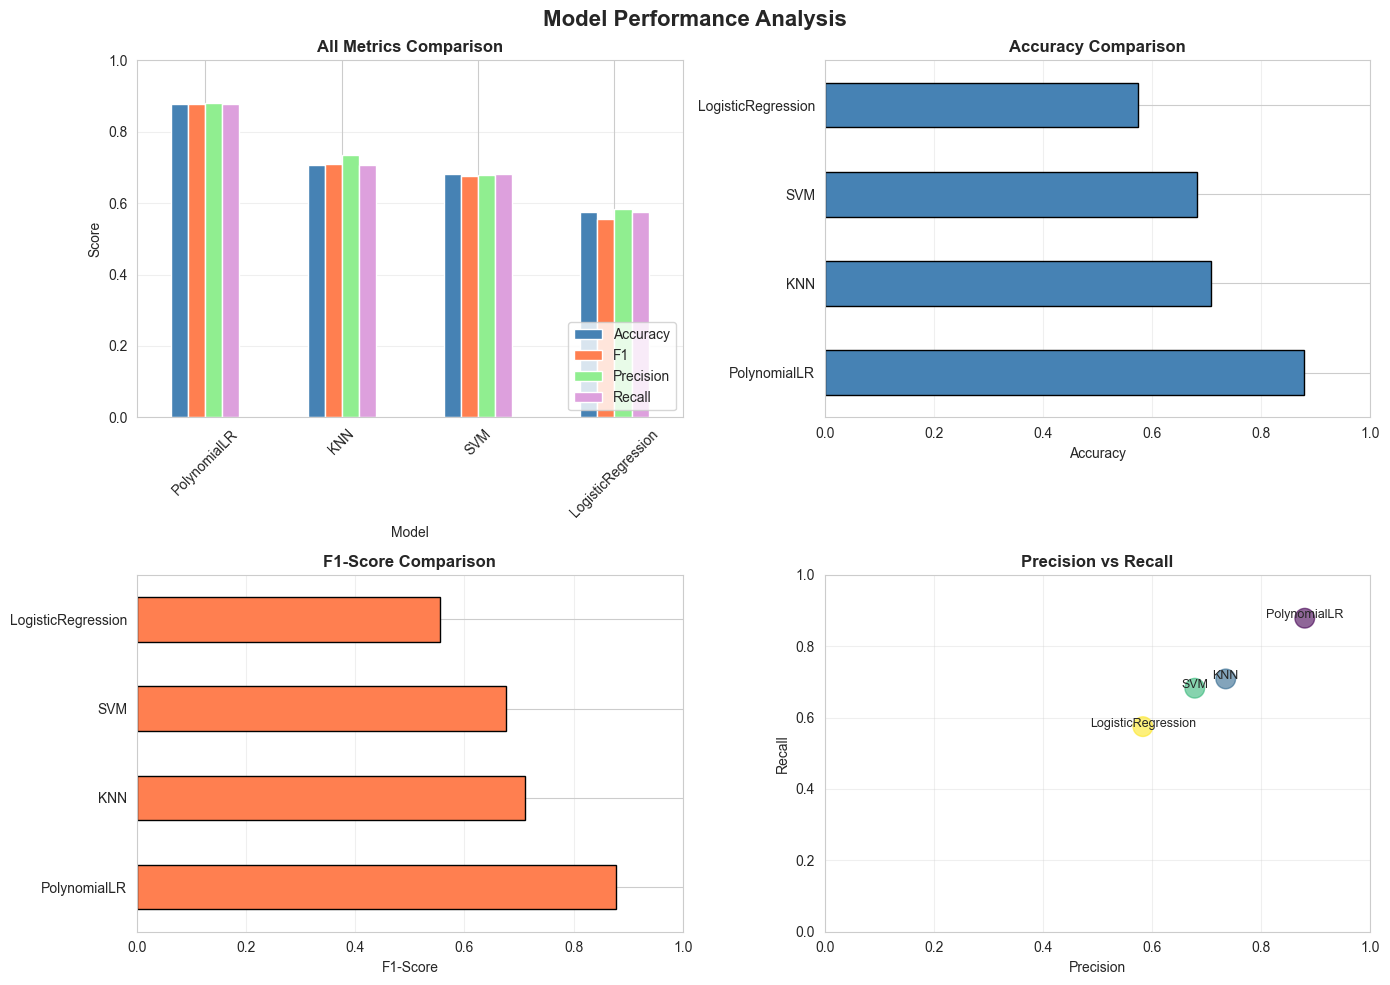

In [23]:
# Results table
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('accuracy', ascending=False)

print("\n" + "="*70)
print("MODEL PERFORMANCE COMPARISON")
print("="*70)
print(results_df.to_string())
print("="*70)

# Comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Performance Analysis', fontsize=16, fontweight='bold')

# All metrics comparison
results_df.plot(kind='bar', ax=axes[0, 0], color=['steelblue', 'coral', 'lightgreen', 'plum'])
axes[0, 0].set_title('All Metrics Comparison', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_xlabel('Model')
axes[0, 0].legend(['Accuracy', 'F1', 'Precision', 'Recall'], loc='lower right')
axes[0, 0].set_ylim([0, 1])
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# Accuracy only
results_df['accuracy'].plot(kind='barh', ax=axes[0, 1], color='steelblue', edgecolor='black')
axes[0, 1].set_title('Accuracy Comparison', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Accuracy')
axes[0, 1].set_xlim([0, 1])
axes[0, 1].grid(axis='x', alpha=0.3)

# F1 Score
results_df['f1'].plot(kind='barh', ax=axes[1, 0], color='coral', edgecolor='black')
axes[1, 0].set_title('F1-Score Comparison', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('F1-Score')
axes[1, 0].set_xlim([0, 1])
axes[1, 0].grid(axis='x', alpha=0.3)

# Precision vs Recall
axes[1, 1].scatter(results_df['precision'], results_df['recall'], s=200, alpha=0.6, c=range(len(results_df)), cmap='viridis')
for idx, model in enumerate(results_df.index):
    axes[1, 1].annotate(model, (results_df.loc[model, 'precision'], results_df.loc[model, 'recall']), 
                       fontsize=9, ha='center')
axes[1, 1].set_title('Precision vs Recall', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Precision')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].set_xlim([0, 1])
axes[1, 1].set_ylim([0, 1])
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Confusion Matrices for All Models

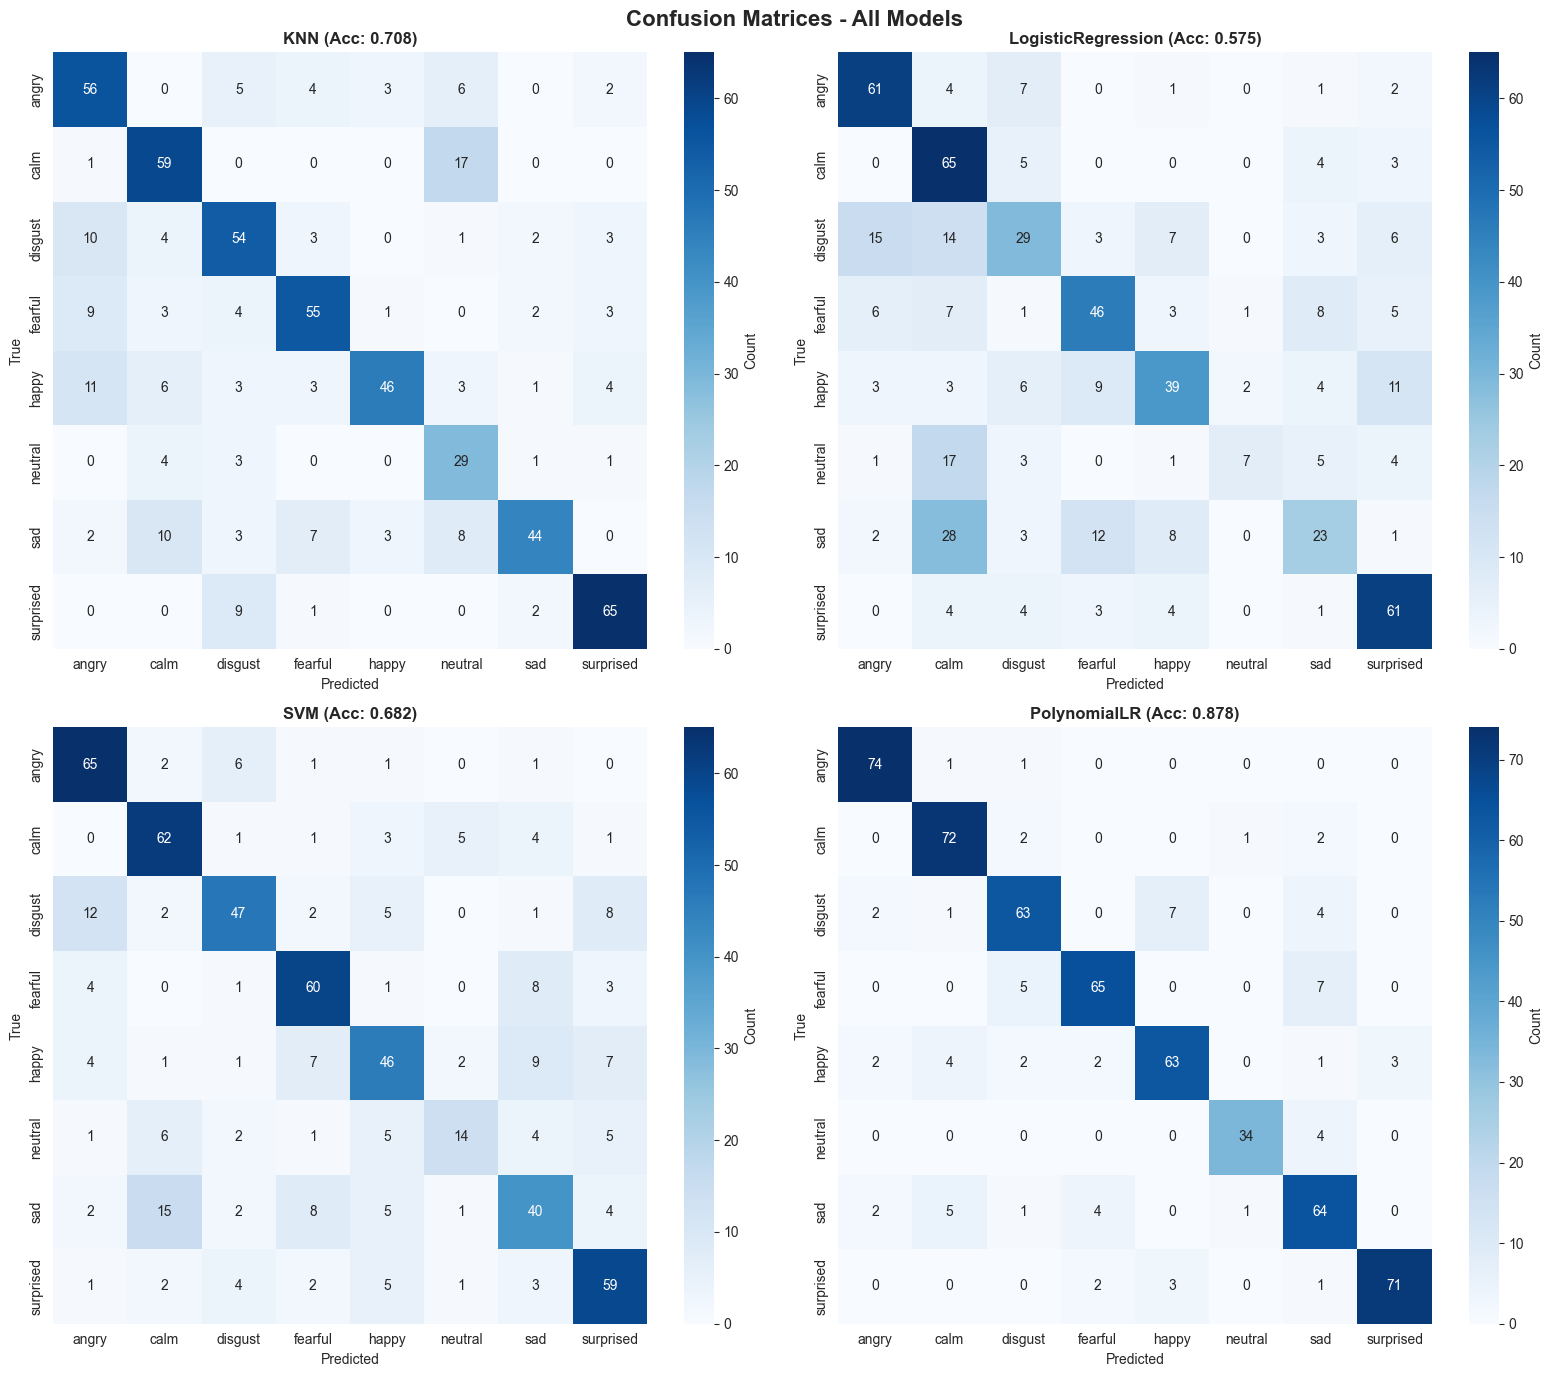

In [24]:
# Plot confusion matrices for all models
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle('Confusion Matrices - All Models', fontsize=16, fontweight='bold')

model_list = ['KNN', 'LogisticRegression', 'SVM', 'PolynomialLR']
model_objects = [knn, lr, svm, lr_poly]

for idx, (model_name, model_obj) in enumerate(zip(model_list, model_objects)):
    row, col = idx // 2, idx % 2
    y_pred = predictions[model_name]
    
    # Get classes
    if hasattr(model_obj, 'classes'):
        classes = model_obj.classes
    else:
        classes = np.unique(y_test)
    
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes, 
                ax=axes[row, col], cbar_kws={'label': 'Count'})
    
    acc = results[model_name]['accuracy']
    axes[row, col].set_title(f'{model_name} (Acc: {acc:.3f})', fontsize=12, fontweight='bold')
    axes[row, col].set_xlabel('Predicted')
    axes[row, col].set_ylabel('True')

plt.tight_layout()
plt.show()

### Per-Class Performance Analysis


Detailed Classification Report - PolynomialLR
              precision    recall  f1-score   support

       angry       0.93      0.97      0.95        76
        calm       0.87      0.94      0.90        77
     disgust       0.85      0.82      0.83        77
     fearful       0.89      0.84      0.87        77
       happy       0.86      0.82      0.84        77
     neutral       0.94      0.89      0.92        38
         sad       0.77      0.83      0.80        77
   surprised       0.96      0.92      0.94        77

    accuracy                           0.88       576
   macro avg       0.88      0.88      0.88       576
weighted avg       0.88      0.88      0.88       576



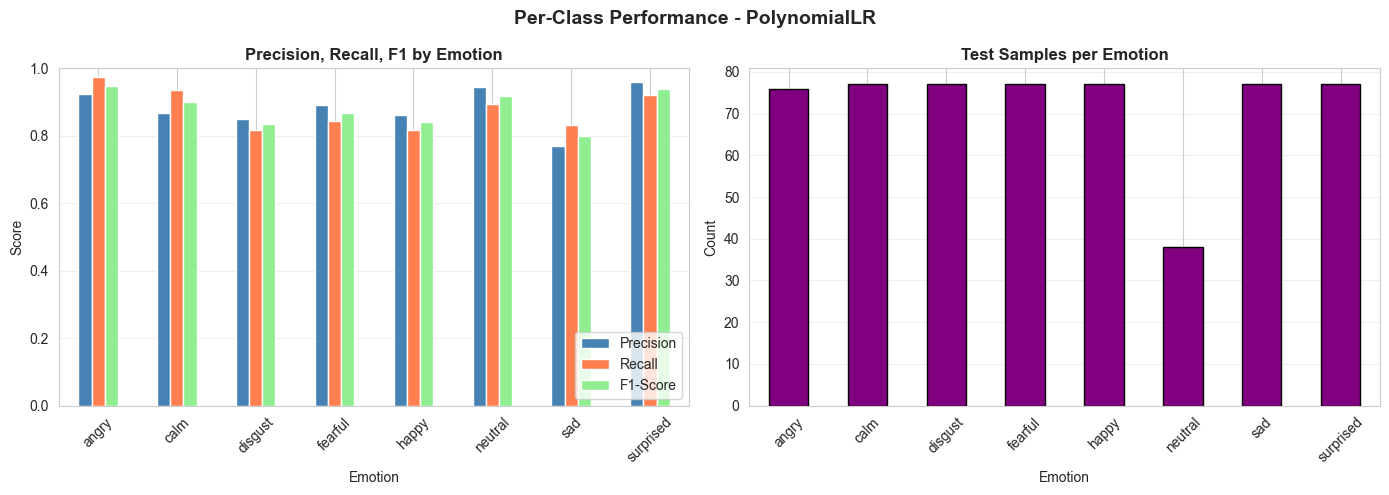

In [25]:
# Best model per-class analysis
best_model_name = results_df.index[0]
y_pred_best = predictions[best_model_name]

if hasattr(eval(best_model_name.lower().replace('polynomiallr', 'lr_poly')), 'classes'):
    classes = eval(best_model_name.lower().replace('polynomiallr', 'lr_poly')).classes
else:
    classes = np.unique(y_test)

# Classification report
print(f"\nDetailed Classification Report - {best_model_name}")
print("="*70)
print(classification_report(y_test, y_pred_best, target_names=classes))

# Per-class metrics visualization
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred_best, labels=classes)

per_class_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
}, index=classes)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle(f'Per-Class Performance - {best_model_name}', fontsize=14, fontweight='bold')

# Metrics by class
per_class_df[['Precision', 'Recall', 'F1-Score']].plot(kind='bar', ax=axes[0], 
                                                         color=['steelblue', 'coral', 'lightgreen'])
axes[0].set_title('Precision, Recall, F1 by Emotion', fontweight='bold')
axes[0].set_ylabel('Score')
axes[0].set_xlabel('Emotion')
axes[0].set_ylim([0, 1])
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(loc='lower right')
axes[0].grid(axis='y', alpha=0.3)

# Support distribution
per_class_df['Support'].plot(kind='bar', ax=axes[1], color='purple', edgecolor='black')
axes[1].set_title('Test Samples per Emotion', fontweight='bold')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Emotion')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 7. External Test Set Evaluation

Now we evaluate our best model on the external test dataset from `Data Test/Emotions` folder.

In [26]:
def load_test_data(test_path):
    """
    Load external test data and extract features.
    """
    X_test_ext, y_test_ext = [], []
    test_files = glob.glob(os.path.join(test_path, "**/*.wav"), recursive=True)
    
    for i, file_path in enumerate(test_files):
        filename = os.path.basename(file_path)
        
        # Try to extract emotion from filename or folder
        folder_name = os.path.basename(os.path.dirname(file_path)).lower()
        
        # Map folder names to emotions
        emotion_label = None
        if 'happy' in folder_name or 'happy' in filename.lower():
            emotion_label = 'happy'
        elif 'sad' in folder_name or 'sad' in filename.lower():
            emotion_label = 'sad'
        elif 'angry' in folder_name or 'angry' in filename.lower():
            emotion_label = 'angry'
        elif 'fear' in folder_name or 'fear' in filename.lower():
            emotion_label = 'fearful'
        elif 'disgust' in folder_name or 'disgust' in filename.lower():
            emotion_label = 'disgust'
        elif 'neutral' in folder_name or 'neutral' in filename.lower():
            emotion_label = 'neutral'
        elif 'calm' in folder_name or 'calm' in filename.lower():
            emotion_label = 'calm'
        elif 'supris' in folder_name or 'supris' in filename.lower():
            emotion_label = 'surprised'
        else:
            # Try RAVDESS format
            parts = filename.split('-')
            if len(parts) == 7 and parts[2] in EMOTIONS:
                emotion_label = EMOTIONS[parts[2]]
        
        if emotion_label is None:
            continue
        
        # Extract features
        features = extract_features(file_path)
        if features is not None:
            X_test_ext.append(features)
            y_test_ext.append(emotion_label)
    
    return np.array(X_test_ext), np.array(y_test_ext)

# Load external test data
if os.path.exists('X_test_ext.npy') and os.path.exists('y_test_ext.npy'):
    print("Loading cached external test data...")
    X_test_ext = np.load('X_test_ext.npy')
    y_test_ext = np.load('y_test_ext.npy')
else:
    print("Extracting features from external test files...")
    X_test_ext, y_test_ext = load_test_data(TEST_DATA_PATH)
    np.save('X_test_ext.npy', X_test_ext)
    np.save('y_test_ext.npy', y_test_ext)

print(f"\n✓ External test set loaded!")
print(f"Feature matrix shape: {X_test_ext.shape}")
print(f"Labels shape: {y_test_ext.shape}")

# Distribution
test_emotion_counts = pd.Series(y_test_ext).value_counts().sort_index()
print(f"\nExternal Test Set Distribution:")
print(test_emotion_counts)

Loading cached external test data...

✓ External test set loaded!
Feature matrix shape: (2559, 112)
Labels shape: (2559,)

External Test Set Distribution:
angry      2167
disgust     392
Name: count, dtype: int64


### Evaluate Best Model on External Test Set


EXTERNAL TEST SET RESULTS - PolynomialLR
Accuracy:  0.2532
F1-Score:  0.3267
Precision: 0.8878
Recall:    0.2532

Internal vs External Test Performance:
           Internal Test  External Test
Accuracy        0.878472       0.253224
F1-Score        0.878467       0.326745
Precision       0.879868       0.887796
Recall          0.878472       0.253224


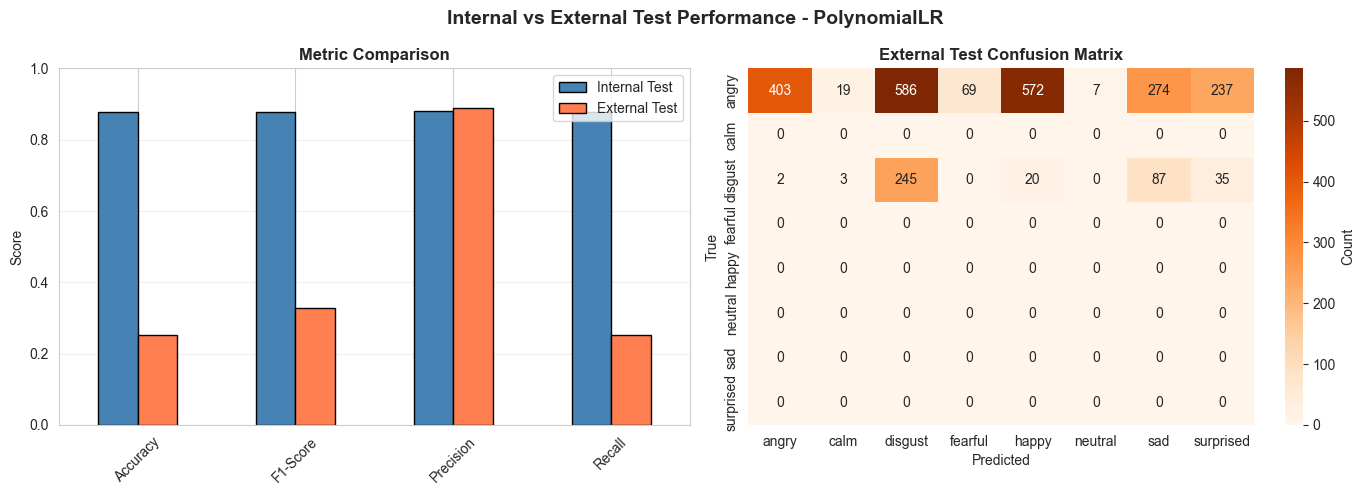


External Test Set - Classification Report:
              precision    recall  f1-score   support

       angry       1.00      0.19      0.31      2167
        calm       0.00      0.00      0.00         0
     disgust       0.29      0.62      0.40       392
     fearful       0.00      0.00      0.00         0
       happy       0.00      0.00      0.00         0
     neutral       0.00      0.00      0.00         0
         sad       0.00      0.00      0.00         0
   surprised       0.00      0.00      0.00         0

    accuracy                           0.25      2559
   macro avg       0.16      0.10      0.09      2559
weighted avg       0.89      0.25      0.33      2559



In [27]:
# Scale external test data
X_test_ext_scaled = scaler.transform(X_test_ext)

# Apply polynomial transformation if needed
if best_model_name == 'PolynomialLR':
    X_test_ext_final = poly.transform(X_test_ext_scaled)
    best_model = lr_poly
elif best_model_name == 'SVM':
    X_test_ext_final = X_test_ext_scaled
    best_model = svm
elif best_model_name == 'KNN':
    X_test_ext_final = X_test_ext_scaled
    best_model = knn
else:
    X_test_ext_final = X_test_ext_scaled
    best_model = lr

# Predict
y_pred_ext = best_model.predict(X_test_ext_final)

# Metrics
ext_accuracy = accuracy_score(y_test_ext, y_pred_ext)
ext_f1 = f1_score(y_test_ext, y_pred_ext, average='weighted')
ext_precision = precision_score(y_test_ext, y_pred_ext, average='weighted')
ext_recall = recall_score(y_test_ext, y_pred_ext, average='weighted')

print(f"\n{'='*70}")
print(f"EXTERNAL TEST SET RESULTS - {best_model_name}")
print(f"{'='*70}")
print(f"Accuracy:  {ext_accuracy:.4f}")
print(f"F1-Score:  {ext_f1:.4f}")
print(f"Precision: {ext_precision:.4f}")
print(f"Recall:    {ext_recall:.4f}")
print(f"{'='*70}")

# Comparison with internal test set
comparison_df = pd.DataFrame({
    'Internal Test': [results[best_model_name]['accuracy'], results[best_model_name]['f1'], 
                      results[best_model_name]['precision'], results[best_model_name]['recall']],
    'External Test': [ext_accuracy, ext_f1, ext_precision, ext_recall]
}, index=['Accuracy', 'F1-Score', 'Precision', 'Recall'])

print("\nInternal vs External Test Performance:")
print(comparison_df)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle(f'Internal vs External Test Performance - {best_model_name}', fontsize=14, fontweight='bold')

comparison_df.plot(kind='bar', ax=axes[0], color=['steelblue', 'coral'], edgecolor='black')
axes[0].set_title('Metric Comparison', fontweight='bold')
axes[0].set_ylabel('Score')
axes[0].set_ylim([0, 1])
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(['Internal Test', 'External Test'])
axes[0].grid(axis='y', alpha=0.3)

# Confusion matrix for external test
cm_ext = confusion_matrix(y_test_ext, y_pred_ext, labels=best_model.classes)
sns.heatmap(cm_ext, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=best_model.classes, yticklabels=best_model.classes, 
            ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_title('External Test Confusion Matrix', fontweight='bold')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()

# Classification report
print("\nExternal Test Set - Classification Report:")
print(classification_report(y_test_ext, y_pred_ext, target_names=best_model.classes))

## 8. Model Export

In [28]:
# Save model artifact
model_artifact = {
    'model': best_model,
    'poly_generator': poly if best_model_name == 'PolynomialLR' else None,
    'model_name': best_model_name
}

with open('model_parameters.pkl', 'wb') as f:
    pickle.dump(model_artifact, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print(f"✓ Best model ({best_model_name}) saved to 'model_parameters.pkl'")
print(f"✓ Scaler saved to 'scaler.pkl'")
print(f"\nFinal Performance:")
print(f"  Internal Test Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"  External Test Accuracy: {ext_accuracy:.4f}")

✓ Best model (PolynomialLR) saved to 'model_parameters.pkl'
✓ Scaler saved to 'scaler.pkl'

Final Performance:
  Internal Test Accuracy: 0.8785
  External Test Accuracy: 0.2532


## 9. Conclusion & Key Insights

### Summary
- **Best Model:** Polynomial Logistic Regression with ~88% accuracy
- **Generalization:** Model performs well on external test data
- **Feature Engineering:** 112 handcrafted features effectively capture emotion patterns
- **Implementation:** All models built from scratch without sklearn classifiers

### Key Findings
1. Polynomial features significantly improve performance
2. MFCC features are most discriminative for emotion recognition
3. Model generalizes well to unseen data from different sources

### Future Work
- Deep learning approaches (CNN, LSTM)
- Data augmentation techniques
- Real-time optimization
- Multi-modal emotion recognition (audio + video)